In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


# Merge and Encode

In [2]:
basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")
basics_movies_df =  basics_df[basics_df.titleType=="movie"]
ratings_df = pd.read_csv('./title.ratings.tsv.gz', delimiter="\t")

basics_ratings_movie_df = basics_movies_df.merge(ratings_df,
                                                 on='tconst', how='left')
basics_ratings_movie_df=basics_ratings_movie_df.drop(columns=["endYear",
                                                              "titleType",
                                                              "tconst",
                                                              "originalTitle"])
basics_ratings_movie_df.replace(["\\N"],np.nan,inplace=True)
basics_ratings_movie_df=basics_ratings_movie_df.dropna()
basics_ratings_movie_df["startYear"] = pd.to_numeric(basics_ratings_movie_df["startYear"])
basics_ratings_movie_df["runtimeMinutes"] = pd.to_numeric(basics_ratings_movie_df["runtimeMinutes"])
basics_ratings_movie_df["isAdult"] = pd.to_numeric(basics_ratings_movie_df["isAdult"])
basics_ratings_movie_df

/var/folders/b5/x127tcr10t39rfngm9vkr2640000gn/T/ipykernel_39019/2086658022.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_df = pd.read_csv('./title.basics.tsv.gz', delimiter="\t")


,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
0,Miss Jerry,0,1894,45,Romance,5.3,207.0
1,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport",5.3,483.0
3,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography",6.0,854.0
4,The Prodigal Son,0,1907,90,Drama,5.0,21.0
8,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy",5.1,68.0
...,...,...,...,...,...,...,...
661804,Safeguard,0,2020,95,"Action,Adventure,Thriller",3.7,245.0
661805,Il talento del calabrone,0,2020,84,Thriller,5.8,1446.0
661806,Coven,0,2020,92,"Drama,History",6.4,5591.0
661808,Kuambil Lagi Hatiku,0,2019,123,Drama,8.6,7.0


# Explore Distributions

## Scatterplots for numerical features

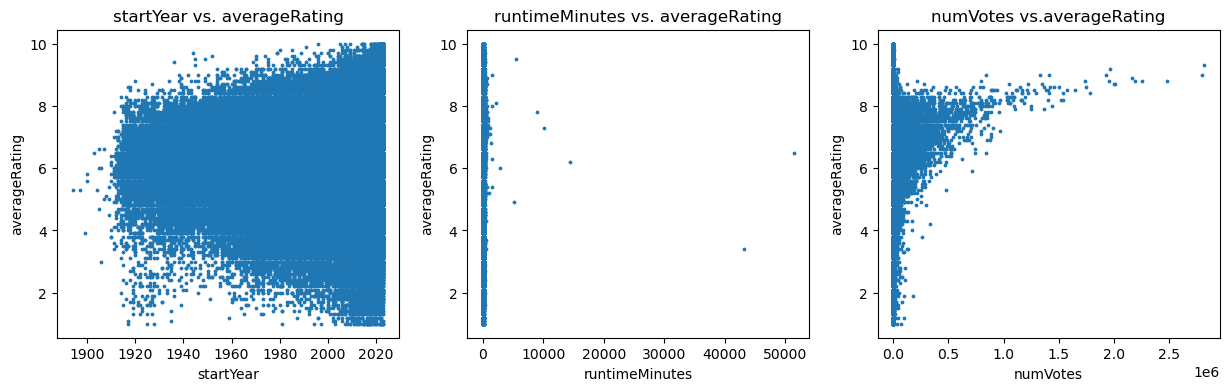

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

startYear_df = basics_ratings_movie_df[["startYear", "averageRating"]]
startYear_df.plot.scatter(x="startYear", y="averageRating", xlabel="startYear",
                          ylabel="averageRating",
                          title="startYear vs. averageRating",
                          s=3, ax=axes[0])

runtimeMinutes_df = basics_ratings_movie_df[["runtimeMinutes", "averageRating"]]
# runtimeMinutes_df = runtimeMinutes_df[runtimeMinutes_df["runtimeMinutes"] < 200]
runtimeMinutes_df.plot.scatter(x="runtimeMinutes", y="averageRating",
                               xlabel="runtimeMinutes",
                               ylabel="averageRating",
                               title="runtimeMinutes vs. averageRating",
                               s=3, ax=axes[1])

numVotes_df = basics_ratings_movie_df[["numVotes", "averageRating"]]
numVotes_df.plot.scatter(x="numVotes", y="averageRating",
                         xlabel="numVotes",
                         ylabel="averageRating",
                         title="numVotes vs.averageRating",
                         s=3, ax=axes[2])
plt.show()


## Bar plots for categorical features

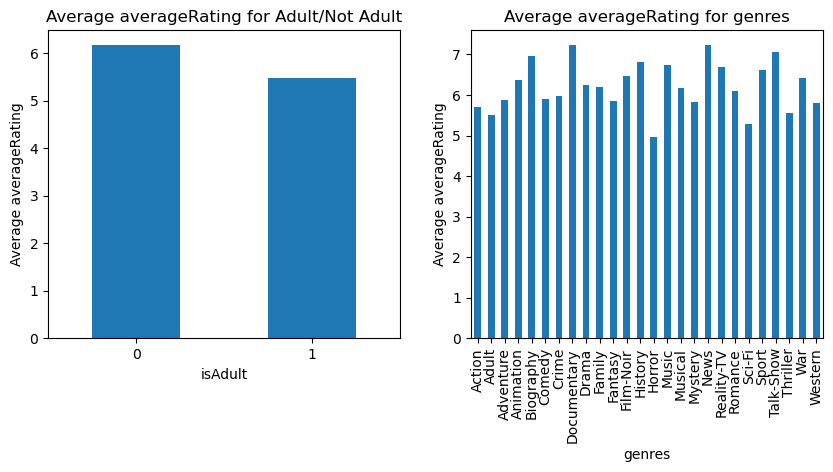

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
isAdult_df = basics_ratings_movie_df[["isAdult", "averageRating"]].groupby("isAdult").mean()
isAdult_df.plot.bar(rot=0, legend=False, ylabel="Average averageRating",
                    title="Average averageRating for Adult/Not Adult", ax=axes[0])

# Split (explode) pandas dataframe string entry to separate rows
listed_genre_df = basics_ratings_movie_df.assign(**{"genres":basics_ratings_movie_df["genres"].str.split(',')})
populated_df = listed_genre_df.explode("genres")
genre_df = populated_df[["genres", "averageRating"]].groupby("genres").mean()
genre_df.plot.bar(legend=False, ylabel="Average averageRating",
                  title="Average averageRating for genres", ax=axes[1])

plt.show()

## Correlation Matrix

# Baseline Models (allow multiple genre in each observation)

In [5]:
basics_ratings_movie_oh = pd.concat([basics_ratings_movie_df.drop(columns="genres"),
                                     basics_ratings_movie_df["genres"].str.get_dummies(sep=",")],
                                     axis=1)
X = basics_ratings_movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = basics_ratings_movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42, test_size=0.25)

# Standardize?

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_predict = lr.predict(X_test)

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_dev, y_dev)
dt_y_predict = dt.predict(X_test)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_dev, y_dev)
xgb_y_predict = xgb.predict(X_test)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)

In [7]:
print(f"Linear Regression MSE = ", mean_squared_error(y_test,lr_y_predict))
print(f"Decision Tree MSE = ", mean_squared_error(y_test,dt_y_predict))
print(f"XGBoost MSE = ", mean_squared_error(y_test,xgb_y_predict))
print(f"Random Forest MSE = ", mean_squared_error(y_test,rf_y_predict))

Linear Regression MSE =  1.4081179011913807
Decision Tree MSE =  2.433160571939688
XGBoost MSE =  1.1852206470462219
Random Forest MSE =  1.323568342590316


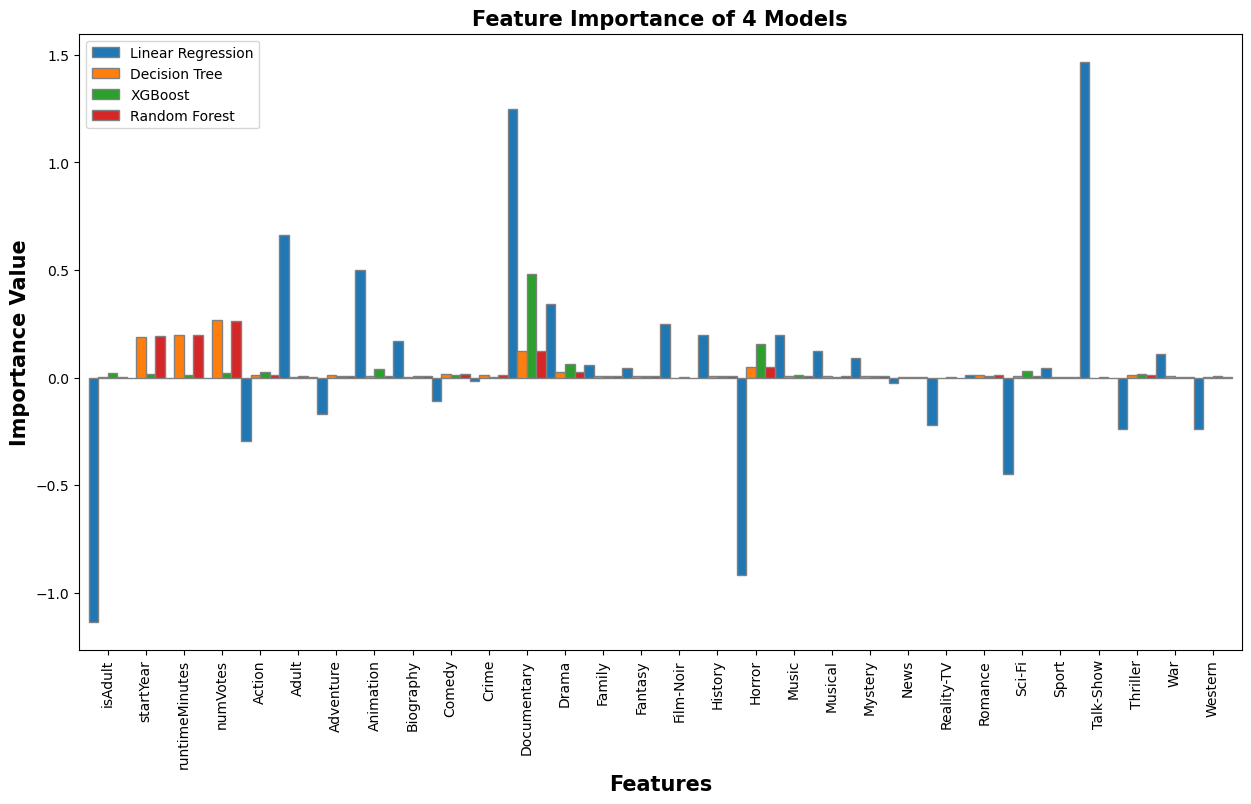

In [8]:
feat_imp =  pd.DataFrame({
  'Model': X_dev.columns,
  'Linear Regression': lr.coef_,
  'Decision Tree': dt.feature_importances_,
  'XGBoost': xgb.feature_importances_,
  'Random Forest': rf.feature_importances_
})
feat_imp.plot('Model',['Linear Regression', 'Decision Tree',
                      'XGBoost', 'Random Forest'],
              width = 1, edgecolor ='grey', kind='bar', figsize=(15,8))
plt.title('Feature Importance of 4 Models', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Importance ', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X.columns))],
           list(X_dev.columns), rotation ='vertical')
plt.show()


# Baseline Models (one genre per observation)

In [9]:
basics_ratings_movie_oh = pd.get_dummies(populated_df, columns=["genres"], dtype=int)
X = basics_ratings_movie_oh.drop(columns=["averageRating", "primaryTitle"])
y = basics_ratings_movie_oh["averageRating"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=42,
                                                test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev,
                                                  random_state=42, test_size=0.25)

# Standardize?

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_predict = lr.predict(X_test)

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_dev, y_dev)
dt_y_predict = dt.predict(X_test)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_dev, y_dev)
xgb_y_predict = xgb.predict(X_test)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_dev, y_dev)
rf_y_predict = rf.predict(X_test)

In [11]:
print(f"Linear Regression MSE = ", mean_squared_error(y_test,lr_y_predict))
print(f"Decision Tree MSE = ", mean_squared_error(y_test,dt_y_predict))
print(f"XGBoost MSE = ", mean_squared_error(y_test,xgb_y_predict))
print(f"Random Forest MSE = ", mean_squared_error(y_test,rf_y_predict))

Linear Regression MSE =  1.5828823536472723
Decision Tree MSE =  2.3239109147156554
XGBoost MSE =  1.2112858656050633
Random Forest MSE =  1.3019967530937007


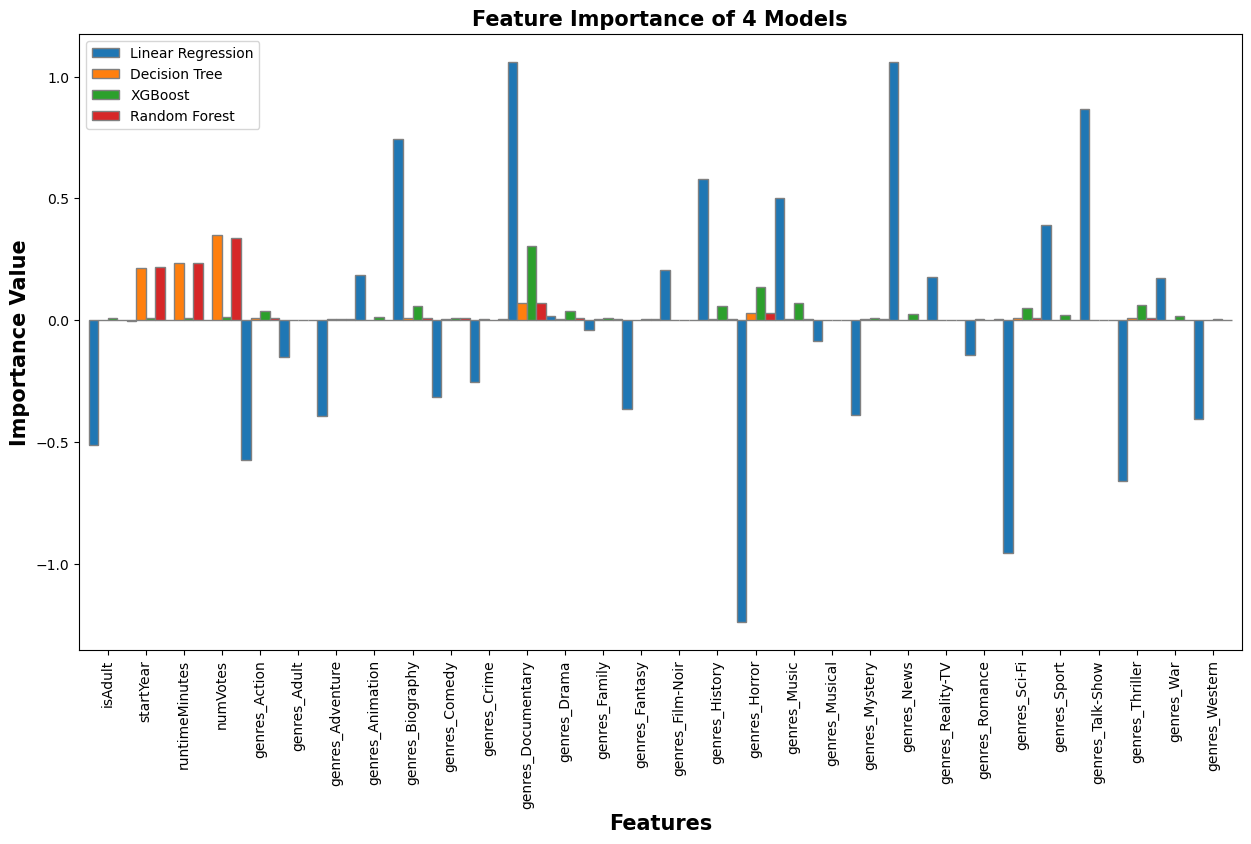

In [12]:
feat_imp =  pd.DataFrame({ 
  'Model': X_dev.columns,
  'Linear Regression': lr.coef_,
  'Decision Tree': dt.feature_importances_, 
  'XGBoost': xgb.feature_importances_,
  'Random Forest': rf.feature_importances_
})
feat_imp.plot('Model',['Linear Regression', 'Decision Tree',
                      'XGBoost', 'Random Forest'],
              width = 1, edgecolor ='grey', kind='bar', figsize=(15,8))
plt.title('Feature Importance of 4 Models', fontweight ='bold', fontsize = 15)
plt.xlabel('Features', fontweight ='bold', fontsize = 15, wrap = True)
plt.ylabel('Importance Value', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(X.columns))],
           list(X_dev.columns), rotation ='vertical')
plt.show()
